## Validate the AB pair PPDF calculation

### Imports

In [1]:
import sys
sys.path.insert(0, '..')
import pymatcal
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

### Read in the configuration. 
The configuration read-in routine should already been tested by `get_config.ipynb`

In [2]:
config = pymatcal.get_config('config-pair-ppdf.yml')

### Formula
$$a_{ij}= \frac{1}{N_j}\sum_{i' \in i}\sum_{j' \in j}\frac{\Omega_{i'j'}}{4\pi} \cdot e^{-\int_{L_s}^{L_p} \mu(l)dl}\left(1-e^{-\int_{L_p}^{L_q} \mu(l)dl}\right)$$

+ $N_j$ is the number of sub-elements in $j_{\textit{th}}$ source voxel.
+ $\Omega_{i'j'}$ s the solid angle of $i_{\textit{th}}'$ sub-element in the detector to $j_{\textit{th}}'$ sub-element in the image volumn(or FOV).
+ $L_s$ is the position of source $j'_{\textit{th}}$ sub-voxel on line L.
+ $L_p$ is the position of the photon incident on the $i'_{\textit{th}}$ sub-element in the detector.
+ $L_q$ is the position of the photon exit from $i'_{\textit{th}}$ sub-element in the detector.
+ $\mu(l)$ is the linear attenuation coefficient.

### Get point A
A index is 200000

In [3]:
pointA=pymatcal.get_img_voxel_center(85, config['img nvx'], config['mmpvx'])
print('point A:',pointA)

point A: [ 0. 30.  0.]


### Show active detectors

In [4]:
print("Number of active detector units:",config['active det'].shape[0])
print(config['active det'])

Number of active detector units: 2
[[11.   21.   21.   27.   -0.5   0.5   5.    0.48]
 [ 0.   10.    9.   15.   -0.5   0.5   2.    0.48]]


### Setup subdivisions pairs
We pick the first active detector in the test

In [5]:
det_subdivs = pymatcal.get_det_subdivs(
    config['active det'][0], config['det nsub'])
img_subdivs = pymatcal.get_img_subdivs(config['mmpvx'], config['img nsub'])
pAs = img_subdivs['coords']+pointA
pBs = det_subdivs['coords']
pAs = pymatcal.coord_transform(
    pymatcal.get_mtransform(config['angle'], -config['dist'], 5), pAs)
abpairs = pymatcal.get_AB_pairs(pAs, pBs)

### Set blocking detector units array and the focused detector unit

In [6]:
blocks = config["det geoms"][config["det geoms"][:,6] != config["active det"][0][6]]
focus_det = np.array([config["active det"][0]])

### Get intersections

In [7]:
intersections_blk = pymatcal.get_intersections_2d(blocks,abpairs)
intersections_det = pymatcal.get_intersections_2d(focus_det,abpairs)

### Plot

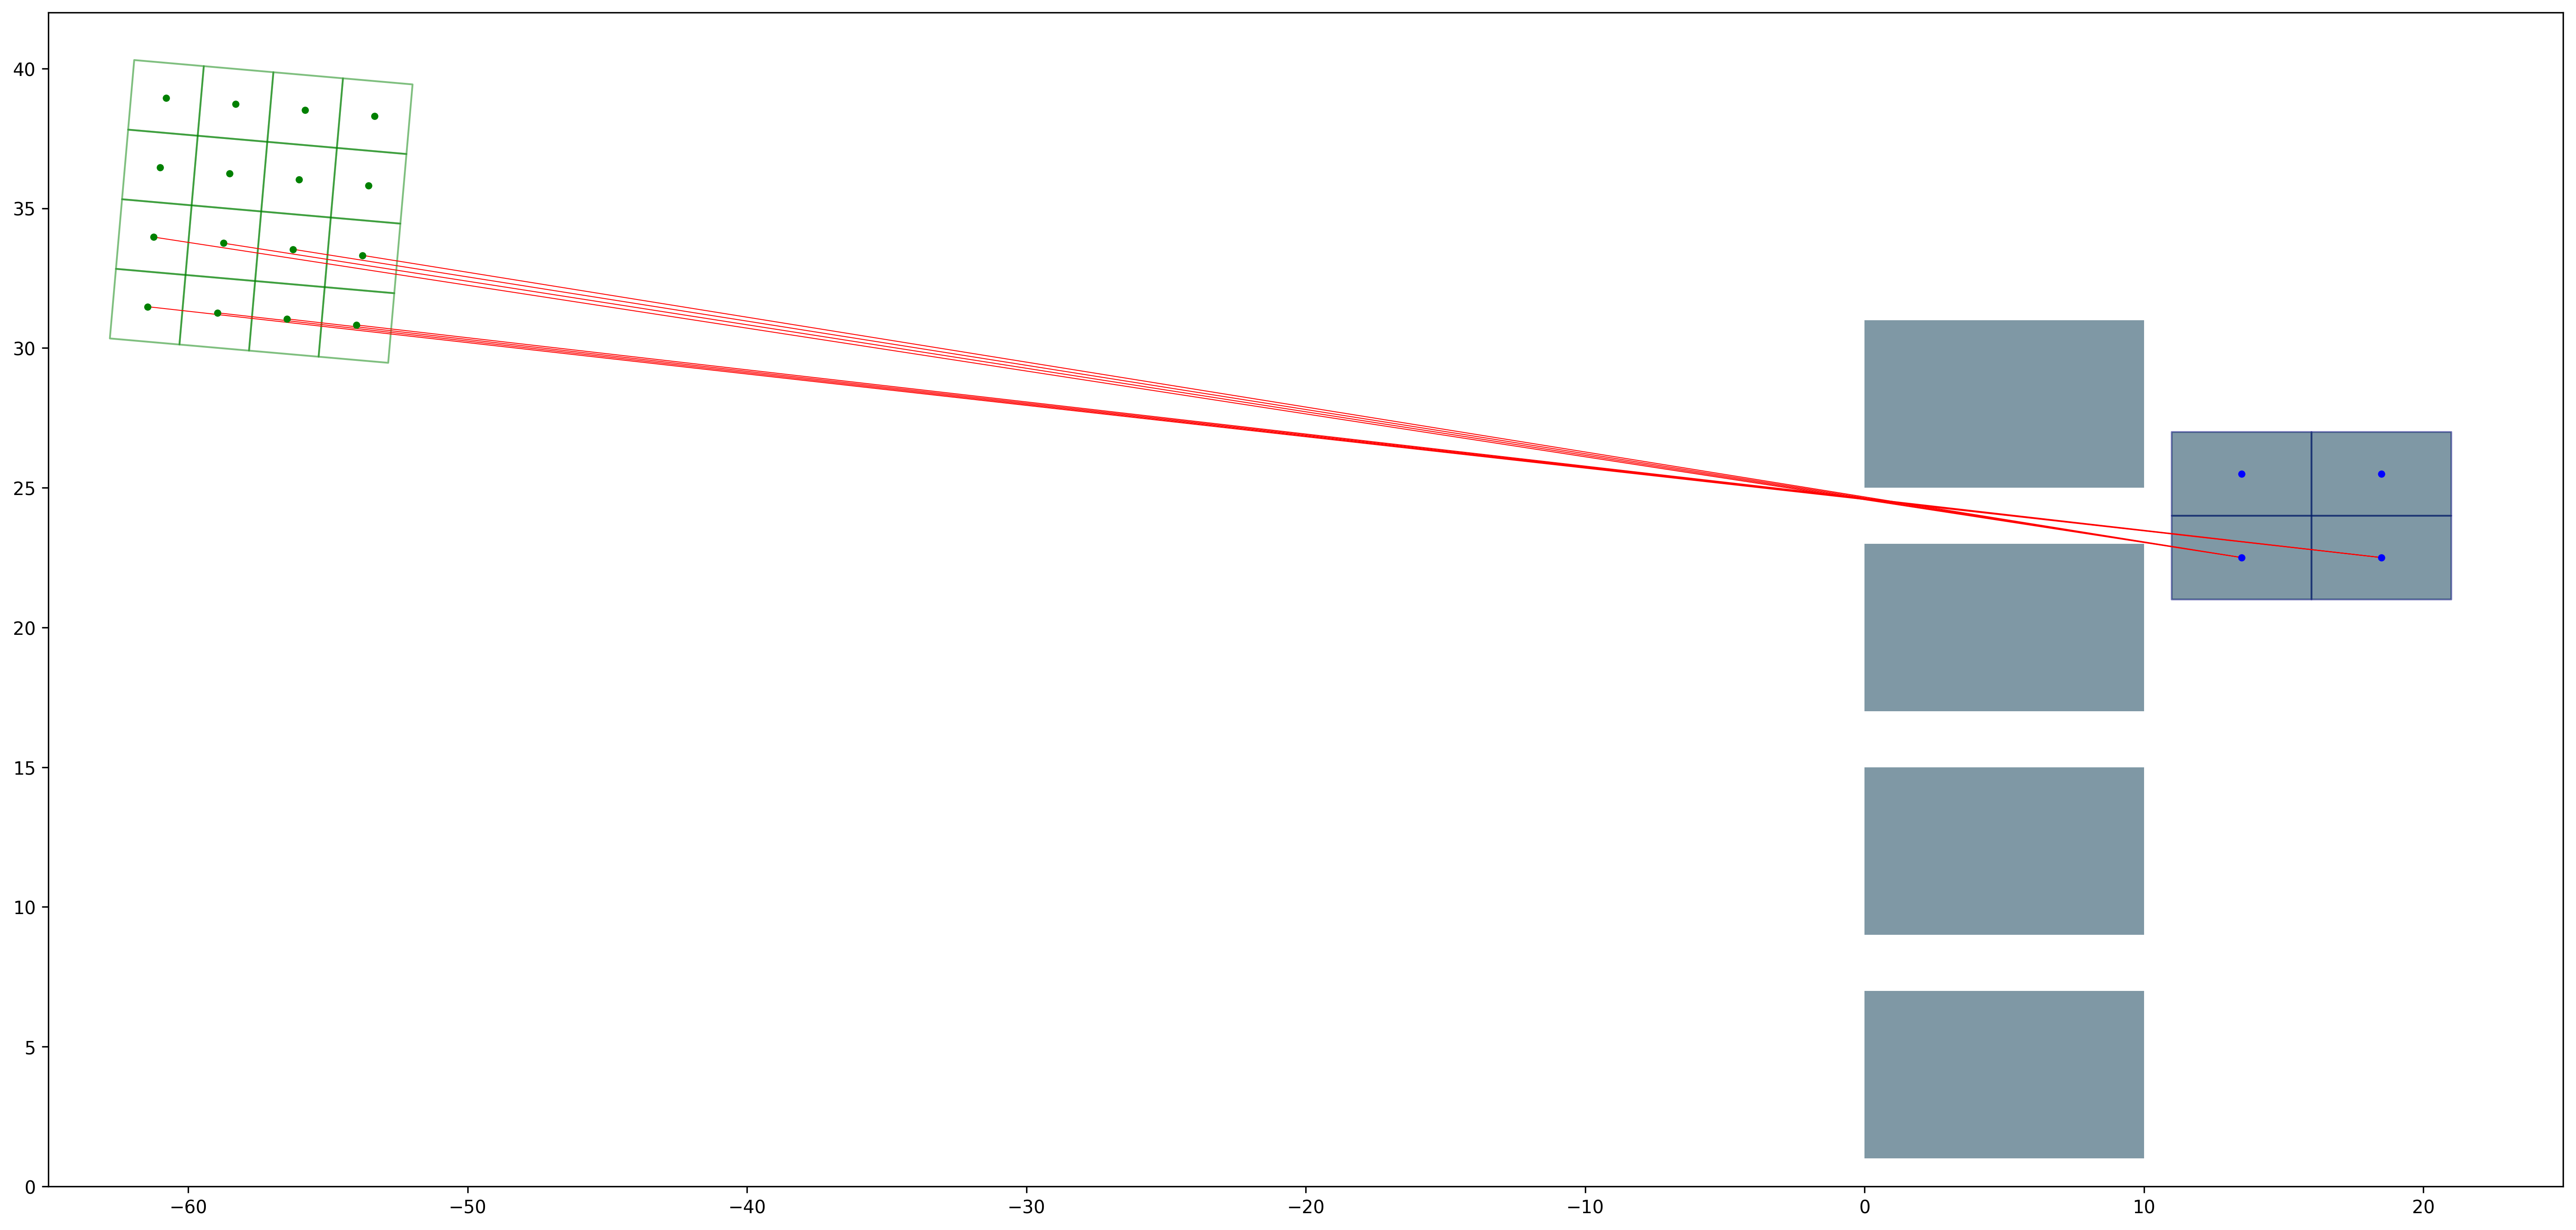

In [9]:
det_subdiv_list = [
    mpl.patches.Rectangle(
        xy[:2] - det_subdivs["incs"][:2] * 0.5,
        det_subdivs["incs"][0],
        det_subdivs["incs"][1],
    )
    for xy in pBs
]
subdiv_inc = np.array(
    [
        config["mmpvx"][0] / config["img nsub"][0],
        config["mmpvx"][1] / config["img nsub"][1],
    ]
)
img_subdiv_list = [
    mpl.patches.Rectangle(
        xy - subdiv_inc * 0.5,
        subdiv_inc[0],
        subdiv_inc[1],
        angle=-config['angle'],
        rotation_point=(xy[0], xy[1]),
    )
    for xy in pAs[:, :2]
]

fig, ax = plt.subplots(figsize=(20, 10), dpi=300)
pc = mpl.collections.PatchCollection(
    img_subdiv_list, ec=(0, 0.5, 0, 0.5), fc="none")
pc1 = mpl.collections.PatchCollection(
    det_subdiv_list, ec=(0, 0, 0.5, 0.5), fc="none")

passIndx = np.all(intersections_blk == 0, axis=0)
idx = 0
for pair in abpairs[passIndx]:
# for pair in abpairs:
    ax.plot(pair[0::3], pair[1::3], "-", c="r", ms=10, lw=0.5, zorder=12)
    idx += 1

block_list = [
    mpl.patches.Rectangle((geom[0], geom[2]),
                          geom[1] - geom[0], geom[3] - geom[2])
    for geom in config["det geoms"]
]
pc2 = mpl.collections.PatchCollection(
    block_list, fc=(0, 0.2, 0.3, 0.5), ec="none", zorder=10
)
ax.add_collection(pc2)
ax.plot(pAs[:, 0], pAs[:, 1], ".", color=(0, 0.5, 0, 1), ms=6, zorder=15)
ax.plot(pBs[:, 0], pBs[:, 1], ".", color=(0, 0, 1, 1), ms=6, zorder=15)
pAs_mins = np.min(pAs, axis=0)
pAs_maxs = np.max(pAs, axis=0)
det_mins = np.min(config["det geoms"], axis=0)
det_maxs = np.max(config["det geoms"], axis=0)
ax.set_xlim(-65, 25)
ax.set_ylim(0, 42)

ax.add_collection(pc)
ax.add_collection(pc1)
ax.set_aspect("equal")
fig.tight_layout()

### Solid angle calculation
$$\frac{\Omega_{i',j'}}{4\pi}$$

In [24]:
print(det_subdivs['incs'])
for idx in range(1,4):
    print(idx%3,(idx+1)%3)

[5. 3. 1.]
1 2
2 0
0 1


In [52]:
def get_solid_angles(abpairs,incs):
    subAreas = np.array([incs[1]*incs[2],incs[2]*incs[0],incs[0]*incs[1]])
    ab_vec = abpairs[:, 3:] - abpairs[:, 0:3]
    ab_length = np.linalg.norm(ab_vec, axis=1)
    # print((ab_length**3 * 4.0 * np.pi).shape)
    return np.sum(np.abs(ab_vec) * subAreas) / (ab_length**3 * 4.0 * np.pi)
def get_norm_areas(abpairs,incs):
    subAreas = np.array([incs[1]*incs[2],incs[2]*incs[0],incs[0]*incs[1]])
    print(subAreas)
    ab_vec = abpairs[:, 3:] - abpairs[:, 0:3]
    ab_length = np.linalg.norm(ab_vec, axis=1)
    # print((ab_length**3 * 4.0 * np.pi).shape)
    return np.sum(np.abs(ab_vec) * subAreas) / ab_length


sa_terms = get_solid_angles(abpairs,det_subdivs['incs'])
print(sa_terms.shape)

(64,)


In [53]:
nvx_total=np.prod(config['img nsub'])
thisdet=config['active det'][0]
AB_pair=np.array([[pointA[0],pointA[1],pointA[2],np.sum(thisdet[0:2])*0.5,np.sum(thisdet[2:4])*0.5,np.sum(thisdet[4:6])*0.5]])
det_incs=np.array([thisdet[1]-thisdet[0],thisdet[3]-thisdet[2],thisdet[5]-thisdet[4]])
sa_terms_whole = get_solid_angles(AB_pair,det_incs)

In [54]:

print(sa_terms_whole)
print(np.sum(sa_terms)/nvx_total)

[0.00248794]
0.01387188006065623


In [55]:
print(sa_terms)

[0.00325154 0.00329033 0.00268574 0.00271391 0.00323594 0.0032874
 0.00267574 0.00271316 0.00320996 0.00327362 0.00265813 0.00270452
 0.00317401 0.00324922 0.00263316 0.00268812 0.00359706 0.00364164
 0.00295244 0.00298447 0.0035786  0.00363816 0.00294073 0.00298359
 0.00354789 0.00362185 0.00292012 0.00297347 0.00350545 0.00359299
 0.00289094 0.00295427 0.00399331 0.00404479 0.00325564 0.00329222
 0.00397134 0.00404065 0.00324186 0.00329119 0.00393483 0.00402123
 0.00321763 0.00327927 0.00388443 0.00398689 0.00318334 0.00325667
 0.00444993 0.00450971 0.00360182 0.00364378 0.00442363 0.00450476
 0.00358551 0.00364256 0.00437995 0.00448148 0.00355686 0.00362845
 0.00431975 0.00444036 0.00351637 0.00360171]


In [56]:
sub_areas= get_norm_areas(abpairs,det_subdivs['incs'])
area = get_norm_areas(AB_pair,det_incs)
print(np.sum(sub_areas)/nvx_total)
print(np.sum(area))
print(det_incs)
print(det_subdivs['incs'])

[ 3.  5. 15.]
[ 6. 10. 60.]
949.0402733332443
9.129209481298185
[10.  6.  1.]
[5. 3. 1.]


In [57]:
print(sub_areas)

[232.8115624  233.73353665 218.43861085 219.19961038 232.43852499
 233.66409749 218.16701988 219.17946769 231.81475358 233.33718518
 217.68736984 218.94660821 230.94628635 232.75602776 217.00376529
 218.50305846 240.78200288 241.77245288 225.44206352 226.25439723
 240.36939438 241.6956021  225.14353954 226.23224664 239.67976233
 241.33386101 224.61650064 225.97620382 238.72023765 240.69104941
 223.86574591 225.48864191 249.31720419 250.38401886 232.90931359
 233.77834935 248.85922857 250.29866314 232.58017646 233.75391488
 248.09414836 249.89696799 231.99930508 233.47150757 247.03043261
 249.18347995 231.17233868 232.93392077 258.47935766 259.63168094
 240.88799319 241.81987319 257.96911859 259.53651771 240.5239125
 241.79282979 257.11719675 259.08876535 239.88163347 241.4803122
 255.93371138 258.29386939 238.96781787 240.88562644]


In [58]:
print(area)

[9.12920948]


In [59]:
print(abpairs)

[[-61.44789187  31.47694486   0.          13.5         22.5
    0.        ]
 [-61.44789187  31.47694486   0.          13.5         25.5
    0.        ]
 [-61.44789187  31.47694486   0.          18.5         22.5
    0.        ]
 [-61.44789187  31.47694486   0.          18.5         25.5
    0.        ]
 [-61.23000251  33.96743161   0.          13.5         22.5
    0.        ]
 [-61.23000251  33.96743161   0.          13.5         25.5
    0.        ]
 [-61.23000251  33.96743161   0.          18.5         22.5
    0.        ]
 [-61.23000251  33.96743161   0.          18.5         25.5
    0.        ]
 [-61.01211316  36.45791835   0.          13.5         22.5
    0.        ]
 [-61.01211316  36.45791835   0.          13.5         25.5
    0.        ]
 [-61.01211316  36.45791835   0.          18.5         22.5
    0.        ]
 [-61.01211316  36.45791835   0.          18.5         25.5
    0.        ]
 [-60.7942238   38.9484051    0.          13.5         22.5
    0.        ]
 [-60.794223